<a href="https://colab.research.google.com/github/cfonderson/portfolio/blob/main/Data%20Science/Financial%20Risk%20Analysis/riskanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Risk Analytics in Banking and Financial Services

Financial risk analytics is an evolving function in the financial sector that provides products and solutions to financial institutions to measure and manage their counterparty credit risk, market risk, regulatory risk capital and derivative valuation adjustments. 

![risk analytics](img/risk.png)

## The Data
This project leverages a financial dataset sourced from Kaggle user `manukulamkombil` to provide insight into whether an organization may face a financial risk or not.

The data has been pre-split into training and testing sets, containing 543 and 233 records, respectively. Seven (7) features were used to predict risk, namely `city`, `location_score`, `internal_audit_score`, `external_audit_score`, `fin_score`, `loss_score`, and `past_results`. 

## Modeling
For this project, classification algorithms were trained and tested to predict financial risk at different locations of the organization. Particularly, Logistic Regression, Decision Tree Classifier, Random Forest Classifier and Dense Neural Network models were evaluated to create a predictive solution for this business.

## Results
The Support Vector Classifier outperformed others with an ROC AUC Score of 0.80 and a precision score of 0.91. Thus, it was subsequently used to analyze financial risk in new (i.e., untrained data).

In [1]:
# data manipulation & visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from keras.callbacks import EarlyStopping

# evaluation 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# other libraries
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# kaggle api credentials
creds = pd.read_csv('api_keys.csv')
kaggle_creds = creds[creds['NAME']=='kaggle']

os.environ['KAGGLE_USERNAME'] = kaggle_creds['USER'].values[0]
os.environ['KAGGLE_KEY'] = kaggle_creds['KEY'].values[0]

# downloading the dataset
! kaggle datasets download -d manukulamkombil/machinehack-financial-risk-prediction
! unzip machinehack-financial-risk-prediction.zip

  0% 0.00/9.46k [00:00<?, ?B/s]
100% 9.46k/9.46k [00:00<00:00, 9.40MB/s]
Archive:  machinehack-financial-risk-prediction.zip
  inflating: Sample_Submission.csv   
  inflating: Test.csv                
  inflating: Train.csv               


In [3]:
# loading the files
df = pd.read_csv('Train.csv')
df.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


## Exploratory data analysis

In [4]:
# checking the dataset shape, columns, looking for null records
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  543 non-null    int64  
 1   Location_Score        543 non-null    float64
 2   Internal_Audit_Score  543 non-null    int64  
 3   External_Audit_Score  543 non-null    int64  
 4   Fin_Score             543 non-null    int64  
 5   Loss_score            543 non-null    int64  
 6   Past_Results          543 non-null    int64  
 7   IsUnderRisk           543 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 34.1 KB


In [5]:
# checking for dduplicate records
df.duplicated().sum()

0

In [6]:
# statistical summary
df.describe()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,19.576427,32.259346,8.189687,7.327808,7.046041,5.530387,0.613260,0.626151
std,14.722687,24.887291,3.312022,3.450667,3.156978,1.839124,0.764509,0.484270
min,0.000000,5.185000,3.000000,3.000000,3.000000,3.000000,0.000000,0.000000
25%,6.000000,13.565000,6.000000,5.000000,5.000000,4.000000,0.000000,0.000000
50%,14.000000,19.803000,8.000000,7.000000,7.000000,6.000000,1.000000,1.000000
75%,37.000000,62.594000,11.000000,10.000000,8.000000,7.000000,1.000000,1.000000
max,44.000000,80.809000,15.000000,15.000000,15.000000,13.000000,10.000000,1.000000


In [7]:
df['IsUnderRisk'].value_counts()

1    340
0    203
Name: IsUnderRisk, dtype: int64

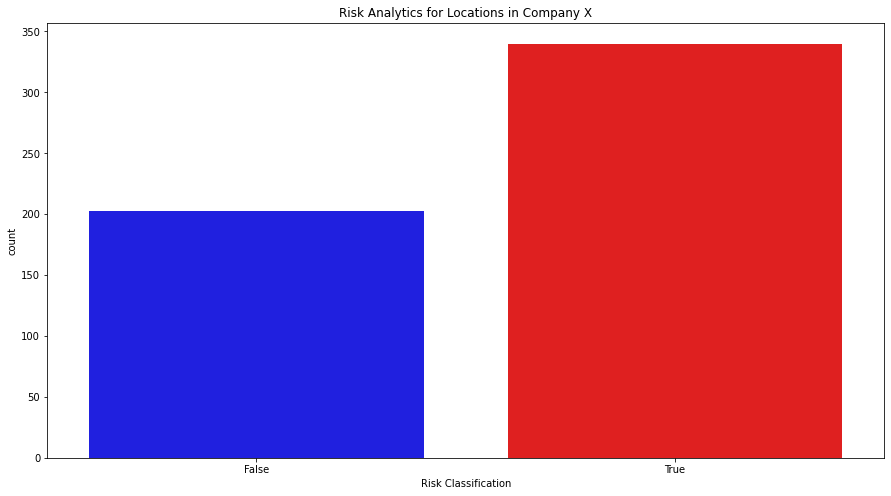

In [8]:
colors = ['#0000ff', '#ff0000']

fig = plt.figure(figsize=(15,8))
sns.countplot(df['IsUnderRisk'].astype('bool'), palette=colors)
plt.xlabel('Risk Classification')
plt.title('Risk Analytics for Locations in Company X')
plt.show()

There are two kinds of features in this dataset:
1.   continuous variables, which include the location, internal audit, external audit, financial and loss scores
2.   categorical variables, including the location (city), past results. The past results values are a score on a discrete scale from 1 to 10



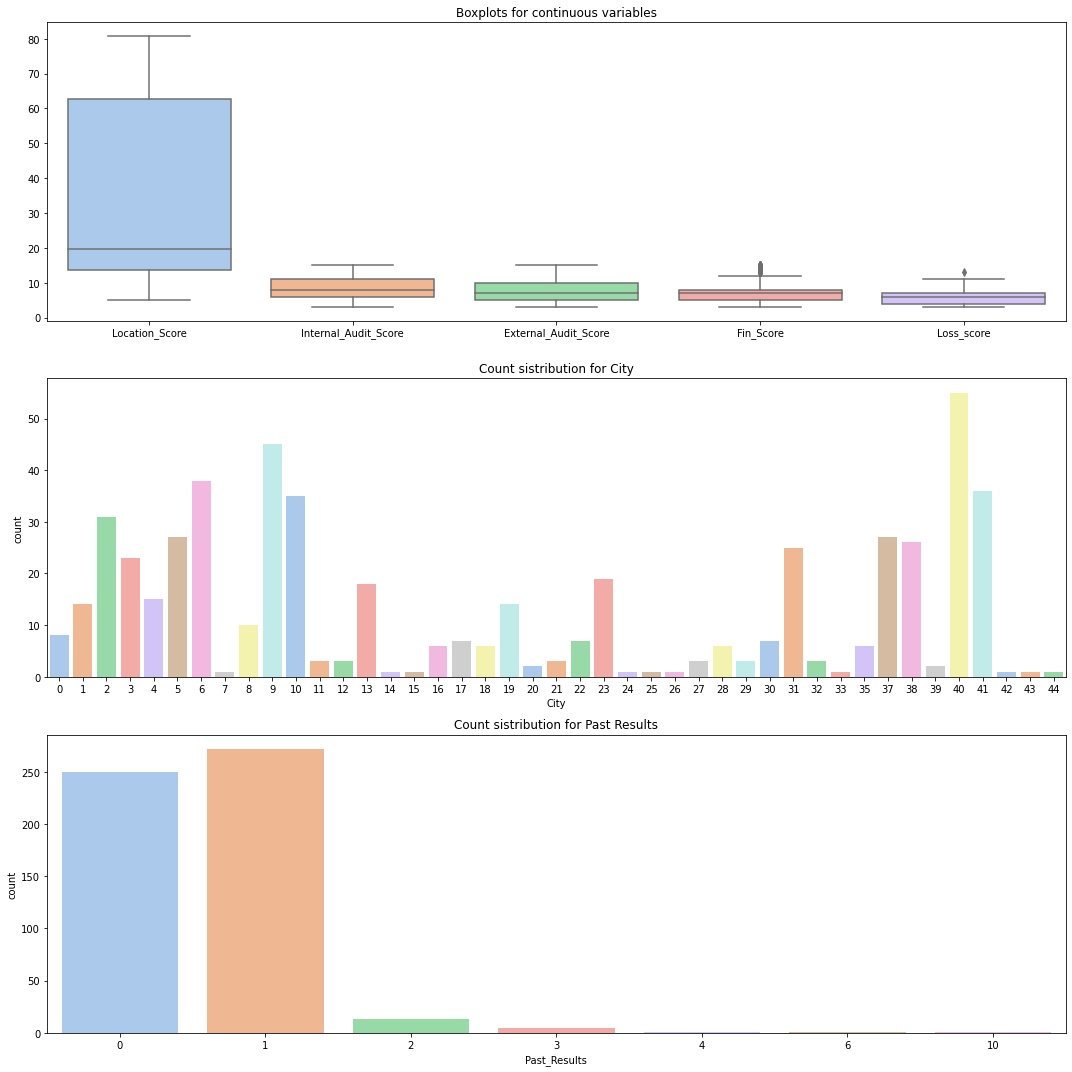

In [9]:
continuous = ['Location_Score', 'Internal_Audit_Score', 
              'External_Audit_Score', 'Fin_Score', 
              'Loss_score']

discrete = ['City', 'Past_Results']

fig, axs = plt.subplots(3, 1, figsize = (15,15))
sns.boxplot(data= df[continuous], palette='pastel', ax=axs[0])
sns.countplot(df[discrete[0]], palette='pastel', ax=axs[1])
sns.countplot(df[discrete[1]], palette='pastel', ax=axs[2])

axs[0].set_title('Boxplots for continuous variables')
axs[1].set_title('Count sistribution for City')
axs[2].set_title('Count sistribution for Past Results')

plt.tight_layout()
plt.show()

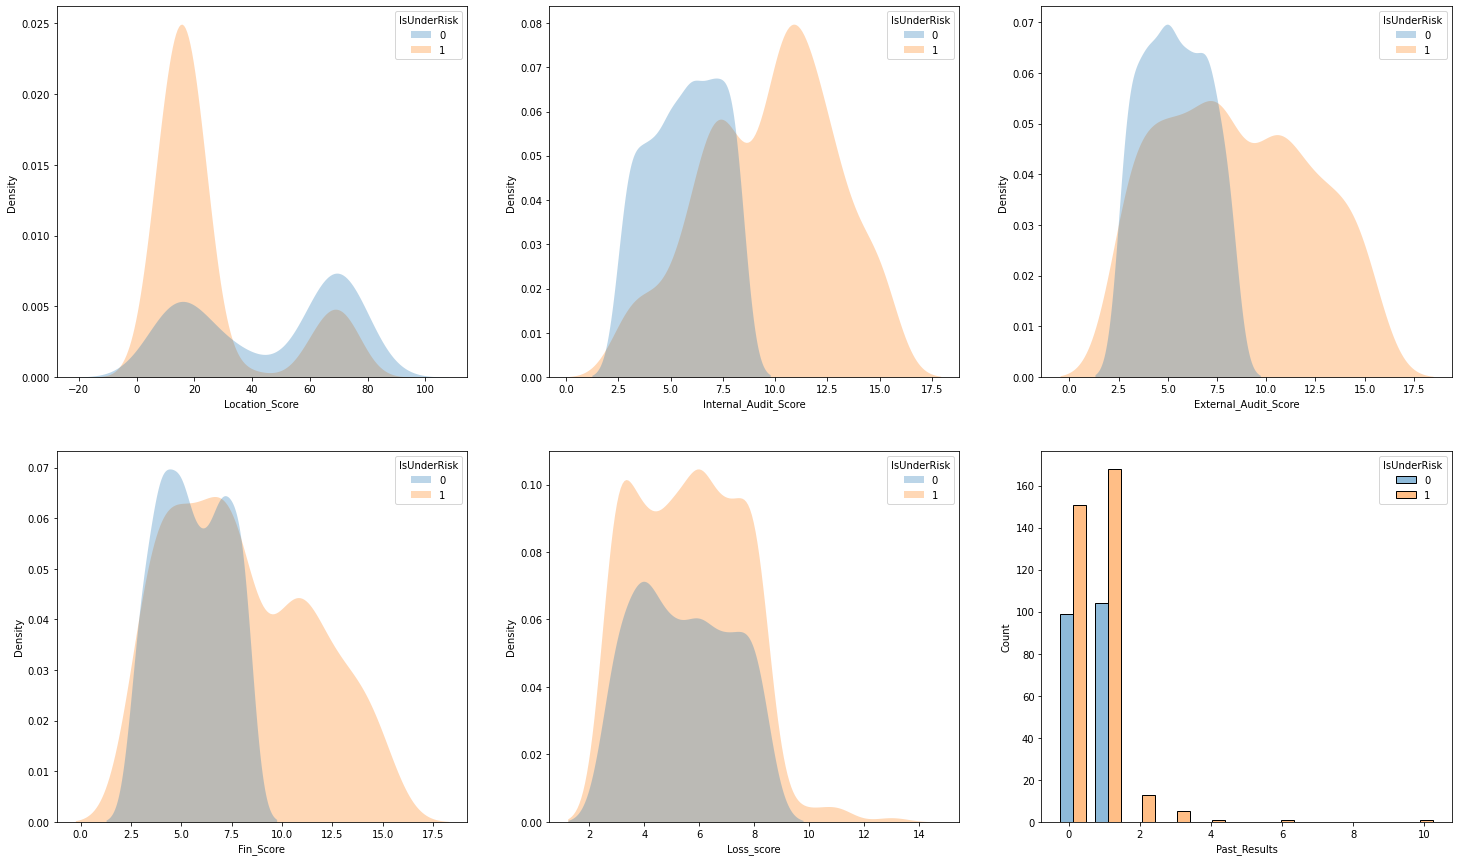

In [10]:
# visualizing variable distributions across different risk classes
fig, axs = plt.subplots(2, 3, figsize = (25,15))

for i,j in zip(range(1,6), continuous):
  plt.subplot(2,3,i)
  sns.kdeplot(data=df, x=df[j], label=j, hue="IsUnderRisk",
              fill=True, alpha=.3, linewidth=0)
  plt.plot()

sns.histplot(data=df, x="Past_Results", hue="IsUnderRisk", 
             multiple='dodge', shrink=3, alpha=0.5, ax=axs[1][2])

plt.show()

## Correlation analyses

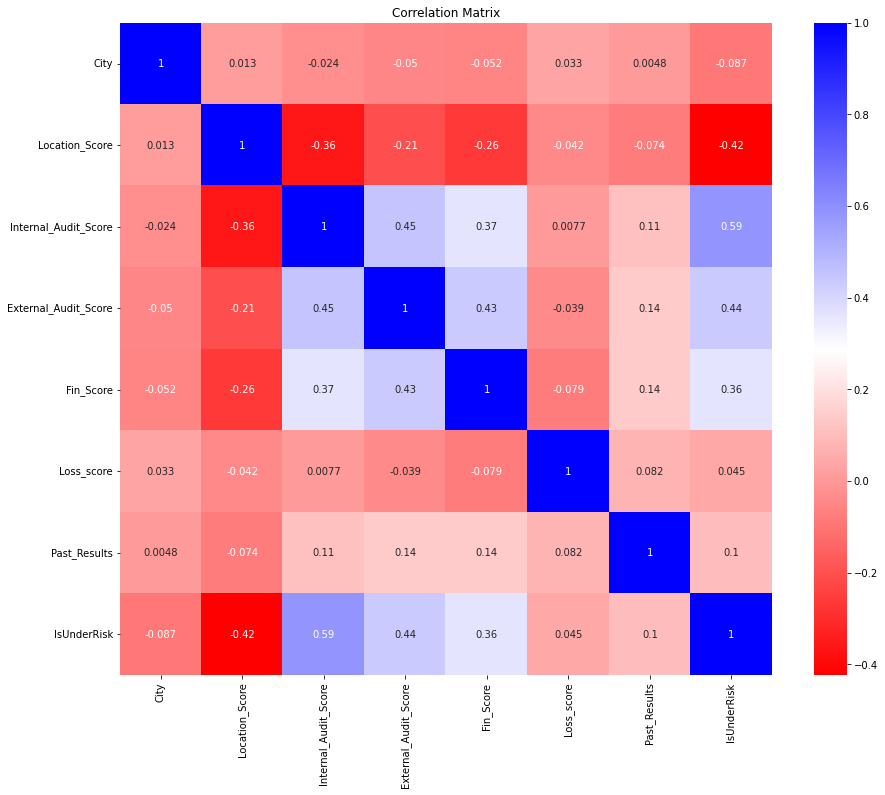

In [11]:
corr = df.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True, cmap='bwr_r', square=True)
plt.title('Correlation Matrix')
plt.show()

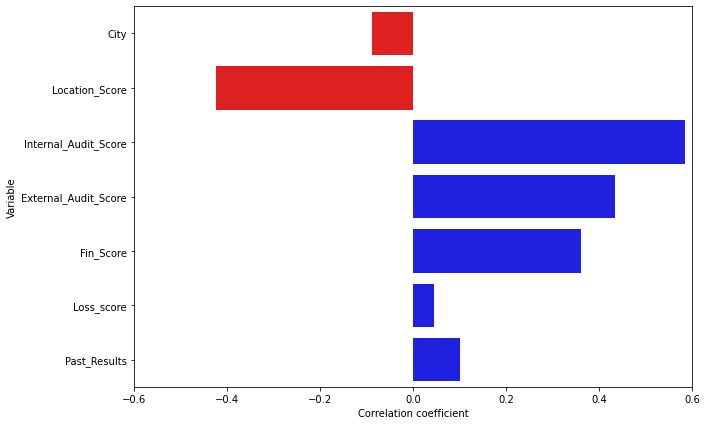

In [13]:
# visualizing correlations with the risk class 
feats = df.drop(['IsUnderRisk'], axis = 1)
corrs = feats.corrwith(df['IsUnderRisk'])

col = []
for val in corrs:
    if val < 0:
        col.append('red')
    else:
        col.append('blue')

plt.figure(figsize = (10,7))
sns.barplot(corrs, feats.columns, palette = col)
plt.xlim(-0.6, 0.6)
plt.xlabel('Correlation coefficient')
plt.ylabel('Variable')
plt.show()

## Machine Learning Modeling

In [14]:
# defining feature and target variables
X = df.drop(['IsUnderRisk'], axis=1)
y = df['IsUnderRisk']

# splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# data preparation, i.e., normalization
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [16]:
# classifier implementation
classifiers = {'Logisitic Regression': LogisticRegression(),
               'Support Vector Classifier': SVC(),
               'Decision Tree Classifier': DecisionTreeClassifier(),
               'Random Forest Classifier': RandomForestClassifier()}

for key, classifier in classifiers.items():
    print(f'\n------------------------------{classifier.__class__.__name__}------------------------------')
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=10)
    test_score = classifier.score(X_test, y_test)
    predicted = classifier.predict(X_test)
    print(f'Cross-validation score: {round(np.mean(training_score), 2)}\nTest score: {round(test_score,2)}')
    print('\nClassification report \n', classification_report(y_test, predicted))



------------------------------LogisticRegression------------------------------
Cross-validation score: 0.82
Test score: 0.76

Classification report 
               precision    recall  f1-score   support

           0       0.57      0.72      0.64        32
           1       0.87      0.78      0.82        77

    accuracy                           0.76       109
   macro avg       0.72      0.75      0.73       109
weighted avg       0.78      0.76      0.77       109


------------------------------SVC------------------------------
Cross-validation score: 0.84
Test score: 0.71

Classification report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.71      1.00      0.83        77

    accuracy                           0.71       109
   macro avg       0.35      0.50      0.41       109
weighted avg       0.50      0.71      0.58       109


------------------------------DecisionTreeClassifier------

In [17]:
# logistic regression optimization using grid search
log_params = {"penalty": ['l1', 'l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_grid = GridSearchCV(LogisticRegression(), log_params, 
                        n_jobs=-1, cv=10)
log_fit = log_grid.fit(X_train, y_train)
log = log_fit.best_estimator_

# model evaluation
cv_score = cross_val_predict(log, X_train, y_train, cv=5,
                             method="decision_function")
test_score = log.score(X_test, y_test)
log_pred = log.predict(X_test)

print(f'Cross-validation score: {round(np.mean(cv_score), 2)}\nTest score: {round(test_score,2)}')
print('\nClassification report \n', classification_report(y_test, log_pred))

Cross-validation score: 0.93
Test score: 0.75

Classification report 
               precision    recall  f1-score   support

           0       0.56      0.75      0.64        32
           1       0.88      0.75      0.81        77

    accuracy                           0.75       109
   macro avg       0.72      0.75      0.73       109
weighted avg       0.78      0.75      0.76       109



In [18]:
# support vector classifier optimization using grid search
svc_params = {'C': [0.5, 0.7, 0.9, 1], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

svc_grid = GridSearchCV(SVC(), svc_params, n_jobs=-1, cv=10)
svc_fit = svc_grid.fit(X_train, y_train)
svc = svc_fit.best_estimator_

# model evaluation
cv_score = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")
test_score = svc.score(X_test, y_test)
svc_pred = svc.predict(X_test)

print(f'Cross-validation score: {round(np.mean(cv_score), 2)}\nTest score: {round(test_score,2)}')
print('\nClassification report \n', classification_report(y_test, svc_pred))

Cross-validation score: 0.91
Test score: 0.78

Classification report 
               precision    recall  f1-score   support

           0       0.59      0.84      0.69        32
           1       0.92      0.75      0.83        77

    accuracy                           0.78       109
   macro avg       0.75      0.80      0.76       109
weighted avg       0.82      0.78      0.79       109



In [19]:
# decision tree classifier optimization using grid search
tree_params = {'criterion': ["gini", "entropy"], 
               'max_depth': list(range(2,4,1)), 
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': list(range(5,7,1))}

tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, 
                         n_jobs=-1, cv=10)
tree_fit = tree_grid.fit(X_train, y_train)
tree = tree_fit.best_estimator_

# model evaluation
cv_score = cross_val_predict(tree, X_train, y_train, cv=5)
test_score = tree.score(X_test, y_test)
tree_pred = tree.predict(X_test)

print(f'Cross-validation score: {round(np.mean(cv_score), 2)}\nTest score: {round(test_score,2)}')
print('\nClassification report \n', classification_report(y_test, tree_pred))

Cross-validation score: 0.54
Test score: 0.71

Classification report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.71      1.00      0.83        77

    accuracy                           0.71       109
   macro avg       0.35      0.50      0.41       109
weighted avg       0.50      0.71      0.58       109



In [20]:
# random forest classifier optimization using grid search
rfc_params = {'n_estimators': [100, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'criterion' : ['gini', 'entropy']}

rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, 
                        n_jobs=-1, cv=10)
rfc_fit = rfc_grid.fit(X_train, y_train)
rfc = rfc_fit.best_estimator_

# model evaluation
cv_score = cross_val_predict(rfc, X_train, y_train, cv=5)

test_score = rfc.score(X_test, y_test)
rfc_pred = rfc.predict(X_test)

print(f'Cross-validation score: {round(np.mean(cv_score), 2)}\nTest score: {round(test_score,2)}')
print('\nClassification report \n', classification_report(y_test, rfc_pred))

Cross-validation score: 0.56
Test score: 0.71

Classification report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.71      1.00      0.83        77

    accuracy                           0.71       109
   macro avg       0.35      0.50      0.41       109
weighted avg       0.50      0.71      0.58       109



## Neural Networks Model

In [21]:
# building the model
dnn = tf.keras.Sequential()
dnn.add(Dense(128, input_shape=(7,),activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation='sigmoid'))

dnn.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = dnn.fit(x=X_train, y=y_train, epochs=100, 
                 validation_data=(X_test, y_test))

Epoch 1/100
14/14 [==============================] - 1s 18ms/step - loss: 0.7267 - accuracy: 0.4240 - val_loss: 1.7064 - val_accuracy: 0.7064
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.7042 - accuracy: 0.4908 - val_loss: 1.7276 - val_accuracy: 0.7064
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 0.7004 - accuracy: 0.5253 - val_loss: 1.7435 - val_accuracy: 0.7064
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6756 - accuracy: 0.5829 - val_loss: 1.7517 - val_accuracy: 0.7064
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.5806 - val_loss: 1.7542 - val_accuracy: 0.7064
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.6658 - accuracy: 0.5945 - val_loss: 1.7464 - val_accuracy: 0.7064
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6244 - val_loss: 1.7641 - val_accuracy: 0.7064
Epoch 8/100


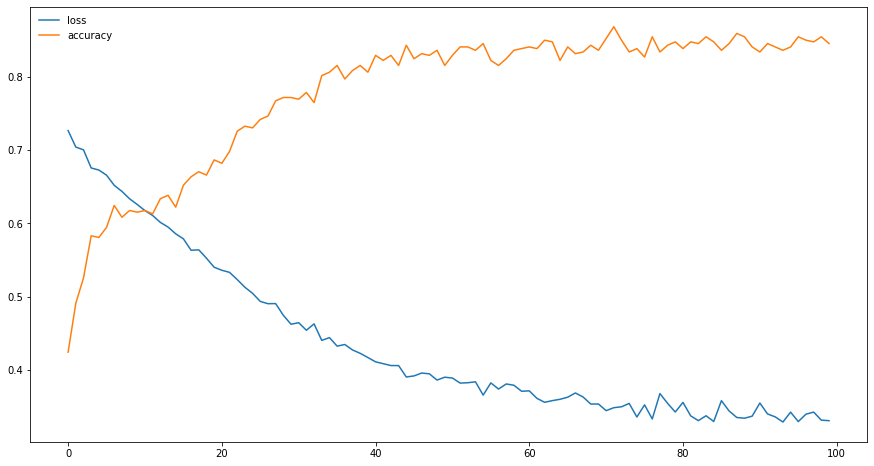

In [22]:
# visualizing the model performance
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.legend(loc='best', frameon=False)
plt.show()

In [23]:
# predicting financial risk probability
dnn_pred_prob = dnn.predict(X_test)

# setting the risk cut-off to 75%
dnn_pred = []
for prob in dnn_pred_prob:
    if prob >= 0.50:
        dnn_pred.append(1)
    else:
        dnn_pred.append(0)

# classification report
print(classification_report(y_test, dnn_pred))

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.34      0.49        32
           1       0.78      0.97      0.87        77

    accuracy                           0.79       109
   macro avg       0.81      0.66      0.68       109
weighted avg       0.80      0.79      0.76       109



## Model Comparisons: Confusion ROC AUC Scores

In [24]:
# confusion matrices
log_cm = confusion_matrix(y_test, log_pred)
svc_cm = confusion_matrix(y_test, svc_pred)
tree_cm = confusion_matrix(y_test, tree_pred)
rfc_cm = confusion_matrix(y_test, rfc_pred)
dnn_cm = confusion_matrix(y_test, dnn_pred)

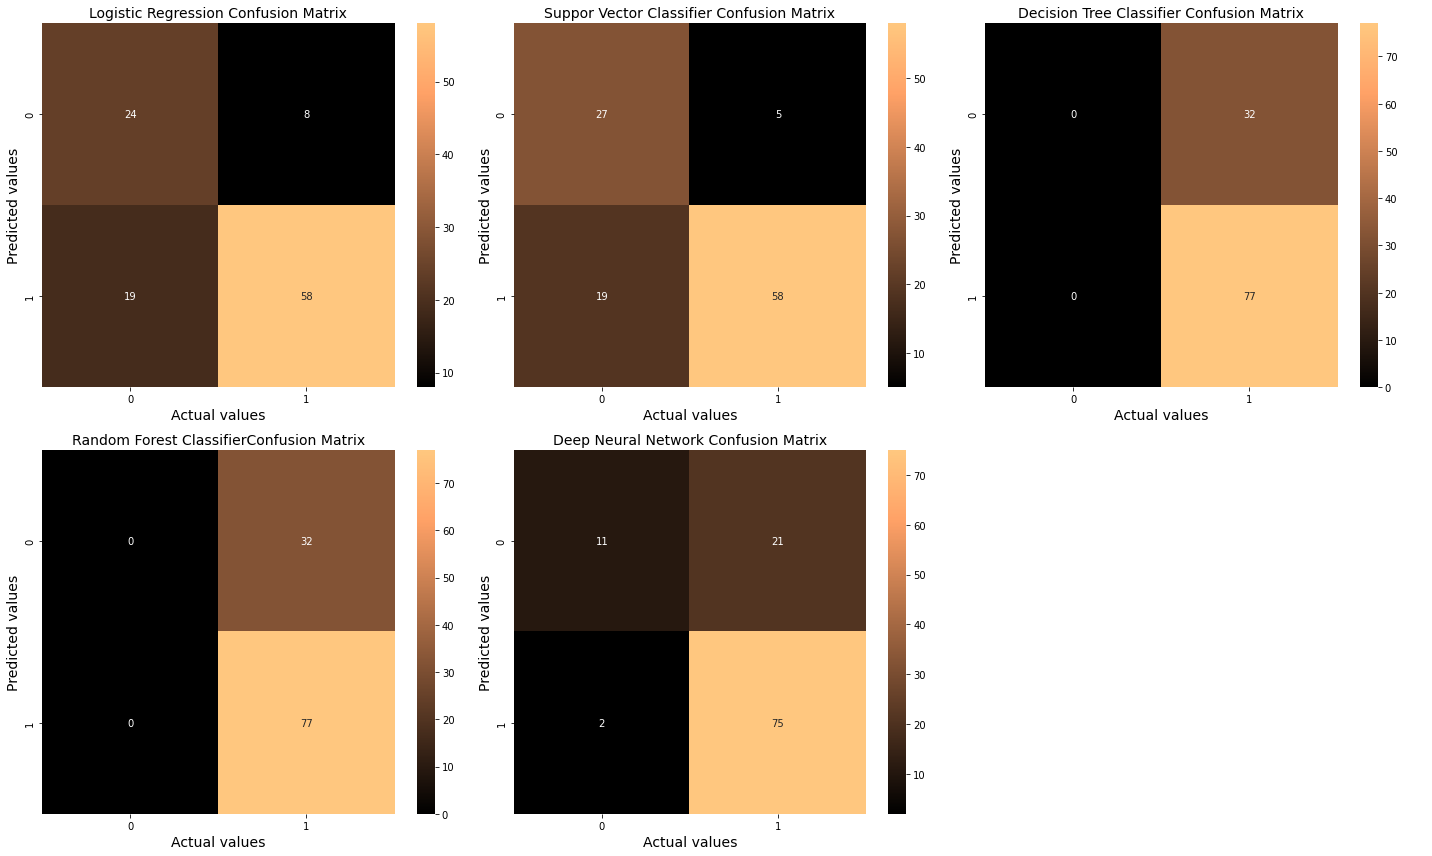

In [25]:
# visualizing confusion matrices
fig, ax = plt.subplots(2, 3,figsize=(20,12))

sns.heatmap(log_cm, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
sns.heatmap(svc_cm, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
sns.heatmap(tree_cm, ax=ax[0][2], annot=True, cmap=plt.cm.copper)
sns.heatmap(rfc_cm, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
sns.heatmap(dnn_cm, ax=ax[1][1], annot=True, cmap=plt.cm.copper)

ax[0][0].set_title("Logistic Regression Confusion Matrix", fontsize=14)
ax[0][0].set_xlabel("Actual values", fontsize=14)
ax[0][0].set_ylabel("Predicted values", fontsize=14)

ax[0][1].set_title("Suppor Vector Classifier Confusion Matrix", fontsize=14)
ax[0][1].set_xlabel("Actual values", fontsize=14)
ax[0][1].set_ylabel("Predicted values", fontsize=14)

ax[0][2].set_title("Decision Tree Classifier Confusion Matrix", fontsize=14)
ax[0][2].set_xlabel("Actual values", fontsize=14)
ax[0][2].set_ylabel("Predicted values", fontsize=14)

ax[1][0].set_title("Random Forest ClassifierConfusion Matrix", fontsize=14)
ax[1][0].set_xlabel("Actual values", fontsize=14)
ax[1][0].set_ylabel("Predicted values", fontsize=14)

ax[1][1].set_title("Deep Neural Network Confusion Matrix", fontsize=14)
ax[1][1].set_xlabel("Actual values", fontsize=14)
ax[1][1].set_ylabel("Predicted values", fontsize=14)

ax[1][2].axis('off')
plt.tight_layout()
plt.show()

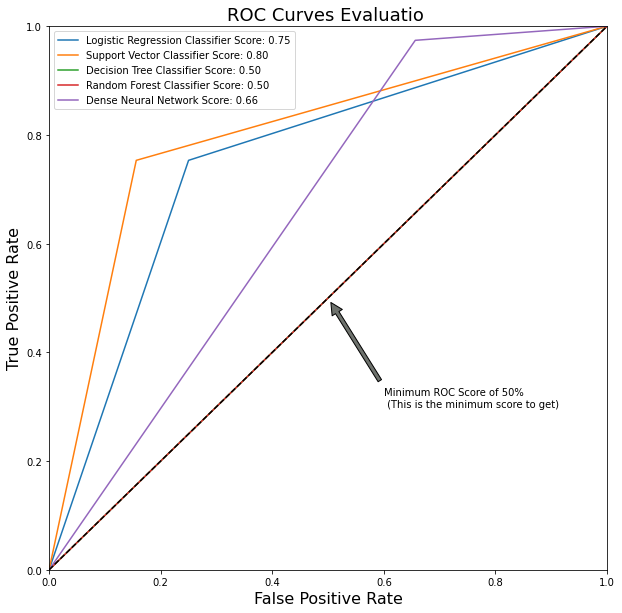

In [26]:
# roc curve
log_fpr, log_tpr, log_thresold = roc_curve(y_test, log_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_test, rfc_pred)
dnn_fpr, dnn_tpr, dnn_threshold = roc_curve(y_test, dnn_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rfc_fpr, rfc_tpr, dnn_fpr, dnn_tpr):
    plt.figure(figsize=(10,10))
    plt.title('ROC Curves Evaluatio ', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.2f}'.format(roc_auc_score(y_test, log_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.2f}'.format(roc_auc_score(y_test, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.2f}'.format(roc_auc_score(y_test, tree_pred)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.2f}'.format(roc_auc_score(y_test, rfc_pred)))
    plt.plot(dnn_fpr, dnn_tpr, label='Dense Neural Network Score: {:.2f}'.format(roc_auc_score(y_test, dnn_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, rfc_fpr, rfc_tpr, dnn_fpr, dnn_tpr)
plt.show()

**Note:** The SVC model outperformed other classification models with a ROC AUC score of 0.80 and a precision score of 0.91. Consequently, it was used to predict the financial risk class of test records

In [27]:
test = pd.read_csv('Test.csv')
test

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results
0,41,18.272,13,12,9,7,0
1,17,64.799,6,10,7,4,1
2,31,68.890,3,3,7,8,0
3,3,16.492,15,10,7,4,1
4,9,17.178,7,3,8,3,1
...,...,...,...,...,...,...,...
228,2,73.165,6,5,5,5,0
229,2,6.952,8,8,5,4,1
230,3,6.796,7,5,4,5,1
231,3,9.197,13,12,10,7,1


In [28]:
test['IsUnderRisk'] = svc.predict(test)
test.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,41,18.272,13,12,9,7,0,1
1,17,64.799,6,10,7,4,1,0
2,31,68.890,3,3,7,8,0,0
3,3,16.492,15,10,7,4,1,1
4,9,17.178,7,3,8,3,1,1


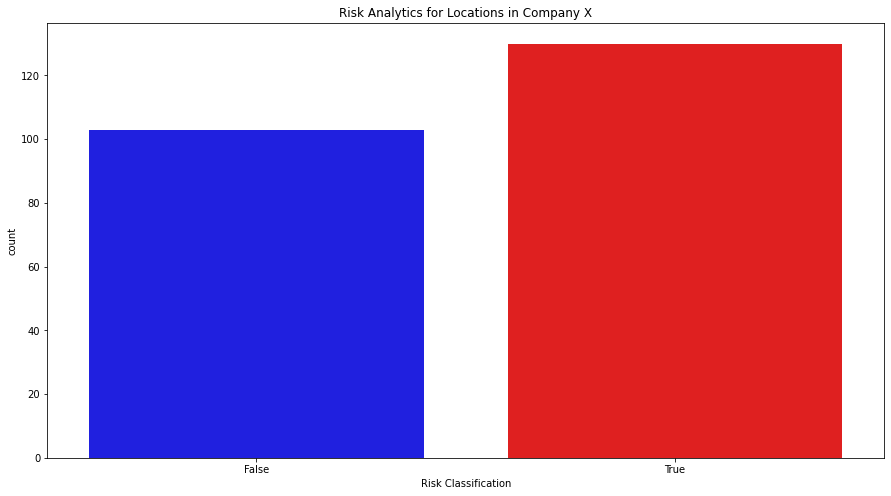

In [29]:
# visualizing financial risk in test dataset
fig = plt.figure(figsize=(15,8))
sns.countplot(test['IsUnderRisk'].astype('bool'), palette=colors)
plt.xlabel('Risk Classification')
plt.title('Risk Analytics for Locations in Company X')
plt.show()

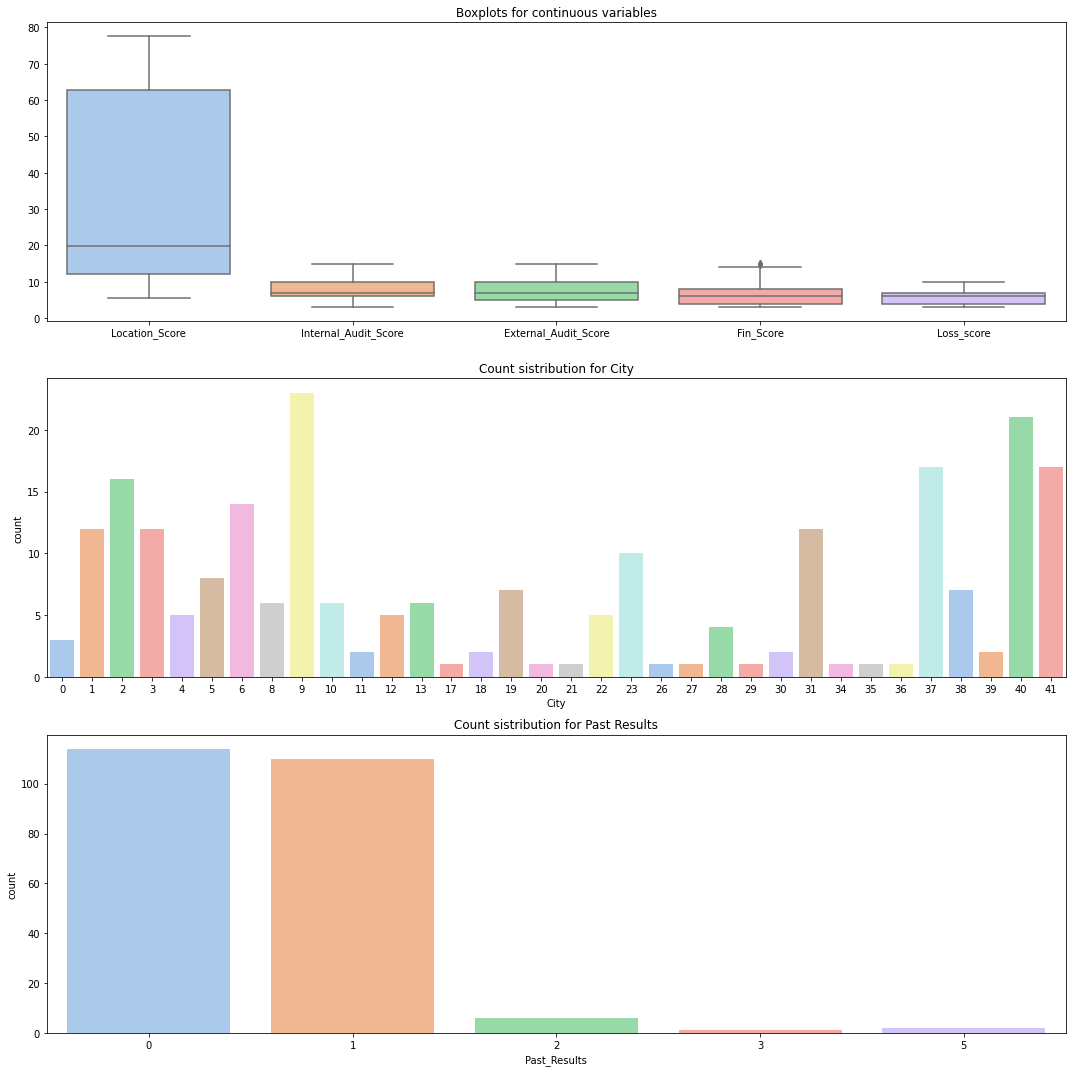

In [30]:
# visualizing data distributions in test dataset
continuous = ['Location_Score', 'Internal_Audit_Score', 
              'External_Audit_Score', 'Fin_Score', 
              'Loss_score']

discrete = ['City', 'Past_Results']

fig, axs = plt.subplots(3, 1, figsize = (15,15))
sns.boxplot(data= test[continuous], palette='pastel', ax=axs[0])
sns.countplot(test[discrete[0]], palette='pastel', ax=axs[1])
sns.countplot(test[discrete[1]], palette='pastel', ax=axs[2])

axs[0].set_title('Boxplots for continuous variables')
axs[1].set_title('Count sistribution for City')
axs[2].set_title('Count sistribution for Past Results')

plt.tight_layout()
plt.show()

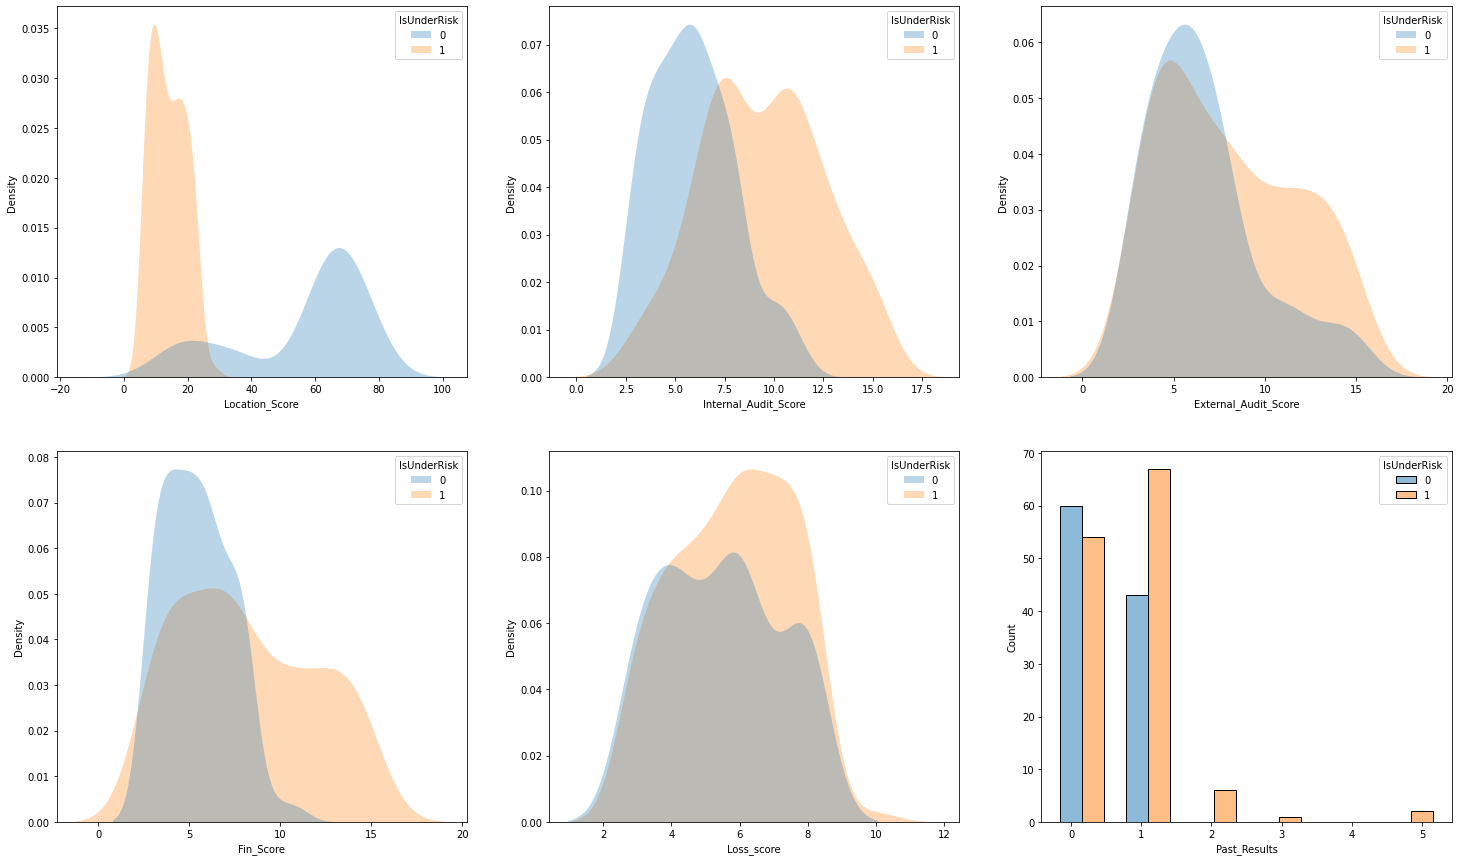

In [31]:
# visualizing variable distributions across different risk classes
fig, axs = plt.subplots(2, 3, figsize = (25,15))

for i,j in zip(range(1,6), continuous):
  plt.subplot(2,3,i)
  sns.kdeplot(data=test, x=test[j], label=j, hue="IsUnderRisk",
              fill=True, alpha=.3, linewidth=0)
  plt.plot()

sns.histplot(data=test, x="Past_Results", hue="IsUnderRisk", 
             multiple='dodge', shrink=2, alpha=0.5, ax=axs[1][2])

plt.show()

## Summary

In the bid to predict financial risk across different locations of an organization, five classification algorthims were considered in this project. The Support Vector Classifier outperformed others with an ROC AUC Score of 0.80 and a precision score of 0.91. Thus, it was subsequently used to analyze financial risk in new (i.e., untrained data).